In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import (LinearRegression, Ridge, Lasso)
%matplotlib inline

In [2]:
# データの読み込み
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# 学習データとテストデータのマージ
train['WhatIsData'] = 'Train'
test['WhatIsData'] = 'Test'
test['SalePrice'] = 9999999999
alldata = pd.concat([train,test],axis=0).reset_index(drop=True)
print(str(train.shape))
print(str(test.shape))

(1460, 82)
(1459, 82)


C:\Users\fujii\Anaconda3\envs\tesorflow-gpu\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [3]:
train.isnull().sum()[train.isnull().sum()>0].sort_values(ascending=False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [4]:
test.isnull().sum()[test.isnull().sum()>0].sort_values(ascending=False)

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageCond        78
GarageQual        78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64

In [5]:
na_col_list = alldata.isnull().sum()[alldata.isnull().sum()>0].index.tolist()
alldata[na_col_list].dtypes.sort_values()

MasVnrArea      float64
GarageArea      float64
TotalBsmtSF     float64
BsmtFinSF1      float64
BsmtFinSF2      float64
GarageYrBlt     float64
BsmtFullBath    float64
BsmtHalfBath    float64
GarageCars      float64
BsmtUnfSF       float64
LotFrontage     float64
GarageType       object
KitchenQual      object
Alley            object
MasVnrType       object
MiscFeature      object
PoolQC           object
SaleType         object
MSZoning         object
GarageQual       object
Functional       object
GarageCond       object
FireplaceQu      object
Fence            object
Exterior2nd      object
Exterior1st      object
Electrical       object
BsmtQual         object
BsmtFinType2     object
BsmtFinType1     object
BsmtExposure     object
BsmtCond         object
GarageFinish     object
Utilities        object
dtype: object

In [6]:
# floatの場合は0
# objectの場合は'NA'
na_float_cols = alldata[na_col_list].dtypes[alldata[na_col_list].dtypes=='float64'].index.tolist()
na_obj_cols = alldata[na_col_list].dtypes[alldata[na_col_list].dtypes=='object'].index.tolist()

for na_float_col in na_float_cols:
    alldata.loc[alldata[na_float_col].isnull(),na_float_col] = 0.0
for na_obj_col in na_obj_cols:
    alldata.loc[alldata[na_obj_col].isnull(),na_obj_col] = 'NA'

In [7]:
alldata.isnull().sum()[alldata.isnull().sum()>0].sort_values(ascending=False)

Series([], dtype: int64)

In [8]:
cat_cols = alldata.dtypes[alldata.dtypes=='object'].index.tolist()
num_cols = alldata.dtypes[alldata.dtypes!='object'].index.tolist()
other_cols = ['Id', 'WhatIsData']
cat_cols.remove('WhatIsData')
num_cols.remove('Id')
alldata_cat = pd.get_dummies(alldata[cat_cols])
all_data = pd.concat([alldata[other_cols], alldata[num_cols],alldata_cat],axis=1)

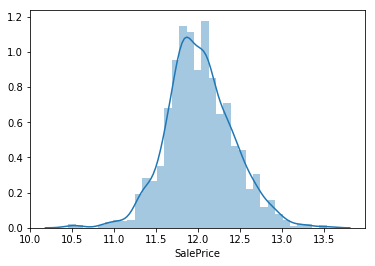

In [9]:
sns.distplot(np.log(train['SalePrice']))

In [10]:
train_ = all_data[all_data['WhatIsData']=='Train'].drop(['WhatIsData','Id'], axis=1).reset_index(drop=True)
test_ = all_data[all_data['WhatIsData']=='Test'].drop(['WhatIsData','SalePrice'], axis=1).reset_index(drop=True)
train_x = train_.drop('SalePrice',axis=1)
train_y = np.log(train_['SalePrice'])
test_id = test_['Id']
test_data = test_.drop('Id',axis=1)

In [11]:
scaler = StandardScaler()
param_grid = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
cnt = 0
for alpha in param_grid:
    ls = Lasso(alpha=alpha)
    pipeline = make_pipeline(scaler, ls)
    X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.3, random_state=0)
    pipeline.fit(X_train, y_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train)))
    test_rmse = np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test)))
    if cnt ==0:
        best_score = test_rmse
        best_estimator = pipeline
        best_param = alpha
    elif best_score > test_rmse:
        best_score = test_rmse
        best_estimator = pipeline
        best_param = alpha
    else:
        pass
    cnt = cnt + 1
    
print('alpha : ' + str(best_param))
print('test score is : ' +str(best_score))

C:\Users\fujii\Anaconda3\envs\tesorflow-gpu\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\fujii\Anaconda3\envs\tesorflow-gpu\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\fujii\Anaconda3\envs\tesorflow-gpu\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\fujii\Anaconda3\envs\tesorflow-gpu\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\fujii\Anaconda3\envs\tesorfl

alpha : 0.01
test score is : 0.18073690872149378


C:\Users\fujii\Anaconda3\envs\tesorflow-gpu\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\fujii\Anaconda3\envs\tesorflow-gpu\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\fujii\Anaconda3\envs\tesorflow-gpu\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\fujii\Anaconda3\envs\tesorflow-gpu\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\fujii\Anaconda3\envs\tesorfl

C:\Users\fujii\Anaconda3\envs\tesorflow-gpu\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\fujii\Anaconda3\envs\tesorflow-gpu\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


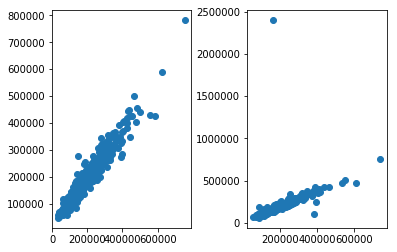

In [12]:
plt.subplots_adjust(wspace=0.4)
plt.subplot(121)
plt.scatter(np.exp(y_train), np.exp(best_estimator.predict(X_train)))
plt.subplot(122)
plt.scatter(np.exp(y_test), np.exp(best_estimator.predict(X_test)))

In [13]:
ls = Lasso(alpha=0.01)
pipeline = make_pipeline(scaler, ls)
pipeline.fit(train_x, train_y)
test_SalePrice = pd.DataFrame(np.exp(pipeline.predict(test_data)),columns=['SalePrice'])
test_Id = pd.DataFrame(test_id,columns=['Id'])
pd.concat([test_Id, test_SalePrice], axis=1).to_csv('output.csv', index=False)

C:\Users\fujii\Anaconda3\envs\tesorflow-gpu\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\fujii\Anaconda3\envs\tesorflow-gpu\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\fujii\Anaconda3\envs\tesorflow-gpu\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
